# CSCI E-81 Machine Learning and Data Mining: Homework 3
**Harvard University**<br>
**Fall 2016**<br>
**Team: Nirmal Labh, Anmol Joshi**<br>
**Due Date: ** Wednesday, October 12th, 2016 at 11:59pm

The following project was a competition held in class, where students were asked to create the best model to train a classifier that classifys given data. The data sets contained over 334 features and thousands of rows of data with a response variable as the class. Students were allowed to use any classification methods at their disposable. 

In this project, we used Amazon Web Services to compute the large data sets for which we have instructions below. But for the purpose of this notebook, we have shown this data be run for a 2000 rows of data. This will show the ROC curves for the different kernels used, for the best C and gamma terms. 

There were three files we used, one was trainingData that contained all the feature data for the training set, then trainingTruth that contained all the classes of the rows and finally testData which was a blind data set that we evaulated our run on by nightly uploads. 

In [1]:
#Load required libraries
import nbpresent
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

    
import csv
import re
import time
import pandas

Below is the function to read the data files. We chose to fill the NA or missing data using fillna function. We fill it with 0 values for our first few runs, but have recently added a new feature to use a self programmed KNN algorithm to fill in the missing data. 

The function works by taking in both the training data and training labels as input, it then splits the training data into two dataframes - one containing complete data and the other missing data. It then iterates through each row of the missing data frame, finds the locations of the missing values and calculates the euclidean distance of the all the features of that row with the full data set. It then finds the k minimum data points and averages the data at the locations of the NaN or NA values in the original row. It then replaces the NaN or NA values with the calculated average. 

We believe this is a fairly accurate method to fill in missing data, rather than just using 0 as we find the closest data points and calculate the mean of the values that are required. 

In [2]:
### Fills in missing data on the training set using KNN like algorithm

#--------  fill_missing_data
# A function for fitting missing data and replacing NaN's and NA's on
# the training set using KNN like algorithm
# Input: 
#      x_train (n x p pandas DataFrame containing all the training features data)
#      y_train (n x 1 pandas DataFrame containing all the training classes)
#      k (integer is the number of neighbors)
# Return: 
#      trainingData (n x p pandas DataFrame containing all the filled training features data)

def fill_missing_data(trainX, trainY, k):

    # Initializes empty array 
    empty = []

    # Uses a for and if statement to store all the rows in the training set with NA or NaN values
    for ii in range(0, len(trainX)):
        a = np.array(trainX.iloc[[ii],:])
        if np.sum(np.isnan(a)) != 0:
            empty = np.append(empty, ii)

    # Splits the training data in two dataframes - missing data and full data for both the training features and classes
    missing_data = trainX.iloc[empty, :]
    missing_data_class = trainY.iloc[empty, :]

    # Finds the full data index values by removing empty indices from all the indicies of the training data
    full_data_range = range(0, len(trainX))
    full_data_loc = [x for x in full_data_range if x not in empty]
    full_data = trainX.iloc[full_data_loc, :]
    full_data_class = trainY.iloc[full_data_loc, :]
    
    #Initializes required indicies for iterations and empty DataFrame to append filled data
    index_values = missing_data.index.values

    filled_data = pandas.DataFrame()
    
    #For loop to index missing data 
    for ii in index_values:
        
        row = missing_data.ix[[ii]]
        
        #Finds the class of row of missing_data
        class_ = int(missing_data_class.ix[ii])
        
        #Splits the full training classes to those equal to the class of the specific row of the full_data
        class_split = full_data_class[full_data_class[0] == class_]
        
        #Finds the index values of the full_data with that class and splices it from full_data to find nearest neighbour
        class_split_index = class_split.index.values
        sub_data = full_data.ix[class_split_index]
        
        #Finds Euclidean Distance by subbing NA with 0 and sorts distance from low to high
        diff = pandas.DataFrame((sub_data.values - row.values)**2, index = sub_data.index.values)
        diff = diff.fillna(0)
        diff = pandas.DataFrame(diff.sum(axis = 1), index = diff.index.values)
        diff = diff.sort(0, ascending = True)
        
        #Finds the index values of the k-nearest neighbors with lowest Euclidean distance
        diff_to_use = diff.index.values[:k]
        
        #Finds the location of the NaN in the row we are iterating
        nanloc = np.where(np.isnan(row))[1]
        
        #Replaces the NaN and NA with the mean of the k-nearest neighbors by taking an average of the 
        row.loc[ii, nanloc] = np.array(np.mean(sub_data.ix[diff_to_use, nanloc]))
        filled_data = filled_data.append(row)
    
    #Adds the index of the originial mising_data to the filled_data
    filled_data = filled_data.set_index(index_values)
    
    #Concatenates the missing_data and full_data and sorts index to now return the training set with all NA and NaN values filled. 
    trainingData = pandas.concat([filled_data, full_data])
    trainingData = trainingData.sort_index(axis = 0)
        
    return trainingData

<b>Binarize Y for all 4 Class Label(s): 1, 2, 3, 4</b>

We read the n x 1 set of data that has 4 distinct class labels. For each label, we create it a column of binary values, 1 for a match with the class label and zero for the other three.

Output produced <b>y</b> is an n x 4 array, each of the 4 columns for each of the class labels.

In [3]:
### Binarizes class labels 

#--------  binarize
# A function to binarize the class labels for example for 4 classes, if Class = 1, output = [1 0 0 0]
# Input: 
#      trainYfile (str filename of the training classes data)
# Return: 
#      label_set (n x 4 arrary of 1's and 0's to binarize class)

def binarize(trainYfile):
    
    # Initializes values for use in the function
    label_set = []
    labels = []
    
    #Reads file containing training classes
    with open('data/' + trainY, 'r') as hw_label:
        hw_label = csv.reader(hw_label, delimiter="\t")
        for row in hw_label:
            y = float(row[0])
            labels.append((y))
    
    #Creates n x 4 array so that if class is equal the real class, then output = 1, otherwise output = 0
    for cls in range(4):
        z = np.array([int(i == (cls+1)) for i in labels])
        label_set.append(z)
    
    #Returns binarized class labels
    return label_set

<b>Grid Search for C and gamma:</b>

Below is a function that calculates the best penalty and regulating parameters for our model. The function takes input in the form of training data, its labels, type of kernels and the choices for C and Gamma (penalty and regulating parameters). It then performs a grid search as returns the best C and gamma for that kernel. This method was useful in calculating the best penalty terms required for our model.


<b>A note on Search and Execution Time(s):</b>

We used 2 splits, 5 C and 5 gmma for imitial search and  with number of fits to search N as:
        N = 2 x (# of gamma in gamma_range) * (# of C in C_range)
we had 50 searches to run through.

Running them in parallel saves significant compute time. Running the N fits serially on our 
personal machines with single/limited numbers of cores ran for hours into over a day when we killed it!
Here, we made use of machine provisioned using <b>Amazon EC2 - <i> spec: 64 cores and 256GB memory</i></b>. 
Making the <b>n_job</b> parameter in gird search to <b>-1</b> made all fits run concurrently, completing 
the grid search in fraction of the time as compared to sequential run.

In [4]:
def get_c_gamma_pll(X, y, kernel, C_range, gamma_range):
    
        # Search for C and gamma
        print(time.asctime( time.localtime(time.time()) ), '- Start .....')       
        print(time.asctime( time.localtime(time.time()) ), '- Before grid .....')
        
        param_grid = dict(gamma=gamma_range, C=C_range)
        
        # Using 2 splits, and n_jobs=-1 for parallel execution of grid search
        cv = StratifiedKFold(n_splits=2)
        print(time.asctime( time.localtime(time.time()) ), '- Before grid search .....')
        
        grid = GridSearchCV(svm.SVC(kernel=kernel, cache_size=25600), param_grid=param_grid, 
                            cv=cv, n_jobs=-1, verbose=1)
        # Fit training data
        print(time.asctime( time.localtime(time.time()) ), '- Before grid fit .....')
        grid.fit(X, y)
        
        print(time.asctime( time.localtime(time.time()) ), '- After grid fit .....')

        print("The best parameters are %s with a score of %0.2f"
              % (grid.best_params_, grid.best_score_))

        return grid

<b>Classification and ROC Analysis - Run classifier with cross-validation and plot ROC curves:</b>

Below function performs the model fitting and computes ROC, AUC, prediction for the class and probabilities for the model. The function takes input in the form of training data, its labels, test data, type of kernels and the choices for C and Gamma (penalty and regulating parameters). Additionally it takes a flag to do the rendering of the plot. This gave us the flexibility of running in batch mode on ASW machine.  This method was useful in getting the final probabilities for each of the class.

In [5]:
def do_classification(Xin, y, cl, XTin, kernel, C, gamma, do_plot):
    
    # Discard irrelevant features using tree-based estimators by computing feature importances
    selector = ExtraTreesClassifier()
    selector = selector.fit(Xin, y)
    selector.feature_importances_ 
    smodel = SelectFromModel(selector, prefit=True)
    
    # obtain all indexes and make column-wise subset of training data
    idxs = smodel.get_support(indices=True)
    
    # feature set for training data after dropping irrelevant features
    X = np.array(Xin)[:, idxs]
    
    # feature set for test data after dropping irrelevant features
    XT = np.array(XTin)[:, idxs]
    print("# of features removed: ", len(Xin[0])-len(X[0]))
             

    # 3-fold split of training data for cross-validation
    # NOTE: Kept it to small value of 3 to avoid computationally very long runs
    cv = StratifiedKFold(n_splits=3)

    # for averaging tpr across 3 fold of the training data split
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    # plot curve color for each of the 3 folds of the split
    colors = cycle(['seagreen', 'yellow', 'blue'])
    lw = 2


    # Iterate across 3 folds - find the best model and auc among those 3 splits of training data
    i = 0
    best_auc = 0
    for (train, test), color in zip(cv.split(X, y), colors):
        print(time.asctime( time.localtime(time.time()) ), '- iteration: ', i)

        # Setup classifier - use large cache (running on AWS machine with total 256GB memory)
        classifier = svm.SVC(cache_size=25600, kernel=kernel, probability=True, C=C, gamma=gamma).fit(X[train], y[train])
        fitted = classifier.predict_proba(X[test])
        
        # Fit the model on training data split and do the prediction of the probas for test data
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])

        # Calculate ROC, AUC and save best classifier
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        if best_auc < roc_auc:
           best_auc = roc_auc
           best_classifier = classifier

        # Plot the ROC Curve for the training fold [1 of the 3]
        if do_plot == 1:
           plt.plot(fpr, tpr, lw=lw, color=color,
                    label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        print('ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i += 1

    # Plot a reference line reflecting random chance
    if do_plot == 1:
       plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
                label='Random Chance')

    # Plot the curve reflecting the average across the 3 training splits
    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    if do_plot == 1:
       plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
                label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    print('Mean ROC (area = %0.2f)' % mean_auc)

    # Get the probas for the best classifier [of the 3 splits]
    print(time.asctime( time.localtime(time.time()) ), '- best classifier probas')
    best_probas_ = best_classifier.predict_proba(XT)[:,1]
    

    # Render the plot details
    if do_plot == 1:
       plt.xlim([-0.05, 1.05])
       plt.ylim([-0.05, 1.05])
       plt.xlabel('False Positive Rate')
       plt.ylabel('True Positive Rate')
       plt.title('ROC - Kernel: ' + kernel + '[C: ' + str(C) + '; gamma: ' + str(gamma) + ']')
       plt.legend(loc="lower right")
       plt.show()
       plt.savefig('plots/'+kernel+str(cls)+'.png')
    
    return best_probas_

In the Main section of the code, the data is read and all NA values are replaced using the KNN algorithm mentioned earlier. 

<b>WARNING:</b> This replacement takes a little over 5 minutes. 

The training labels are then binarized to allow the model to run using the One versus Rest classifiers method. 

We created our baseline model by checking different types of kernels for a small range pf penalty and regularizing parameters. We choose 1, 10 for both Gamma and C. This is run on a small subset of the data to avoid long runs, with this we can evaluate the best kernel and parameters to use. 

The results from the code below is ROC curves for different kernels and different parameters. There are four kernels and four classes, this results in 16 ROC curves. 

2000 2000
2000
2000
Kernel:  linear Class:  0
Sat Oct 15 22:13:54 2016 - Start .....
Sat Oct 15 22:13:54 2016 - Before grid .....
Sat Oct 15 22:13:54 2016 - Before grid search .....
Sat Oct 15 22:13:54 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s finished


Sat Oct 15 22:13:56 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.87
Class:  0
Gamma:  1.0
    C:  1.0
# of features removed:  212
Sat Oct 15 22:13:56 2016 - iteration:  0
ROC fold 0 (area = 0.94)
Sat Oct 15 22:13:57 2016 - iteration:  1
ROC fold 1 (area = 0.94)
Sat Oct 15 22:14:00 2016 - iteration:  2
ROC fold 2 (area = 0.92)
Mean ROC (area = 0.94)
Sat Oct 15 22:14:01 2016 - best classifier probas


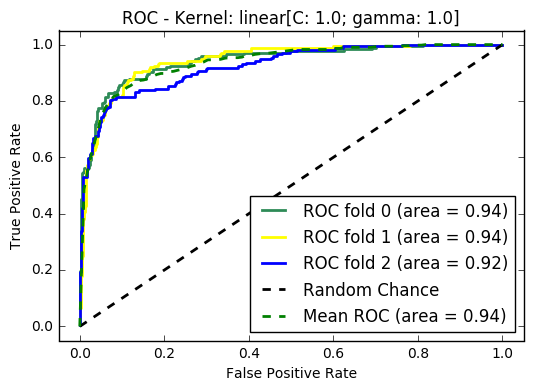

Kernel:  rbf Class:  0
Sat Oct 15 22:14:02 2016 - Start .....
Sat Oct 15 22:14:02 2016 - Before grid .....
Sat Oct 15 22:14:02 2016 - Before grid search .....
Sat Oct 15 22:14:02 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.3s finished


Sat Oct 15 22:14:05 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.74
Class:  0
Gamma:  1.0
    C:  1.0
# of features removed:  212
Sat Oct 15 22:14:05 2016 - iteration:  0
ROC fold 0 (area = 0.31)
Sat Oct 15 22:14:09 2016 - iteration:  1
ROC fold 1 (area = 0.33)
Sat Oct 15 22:14:13 2016 - iteration:  2
ROC fold 2 (area = 0.35)
Mean ROC (area = 0.33)
Sat Oct 15 22:14:17 2016 - best classifier probas


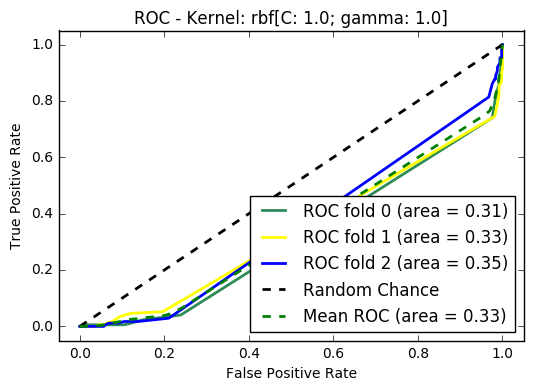

Kernel:  poly Class:  0
Sat Oct 15 22:14:17 2016 - Start .....
Sat Oct 15 22:14:17 2016 - Before grid .....
Sat Oct 15 22:14:17 2016 - Before grid search .....
Sat Oct 15 22:14:17 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.0s finished


Sat Oct 15 22:14:20 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.92
Class:  0
Gamma:  1.0
    C:  1.0
# of features removed:  222
Sat Oct 15 22:14:20 2016 - iteration:  0
ROC fold 0 (area = 0.96)
Sat Oct 15 22:14:22 2016 - iteration:  1
ROC fold 1 (area = 0.95)
Sat Oct 15 22:14:25 2016 - iteration:  2
ROC fold 2 (area = 0.92)
Mean ROC (area = 0.94)
Sat Oct 15 22:14:27 2016 - best classifier probas


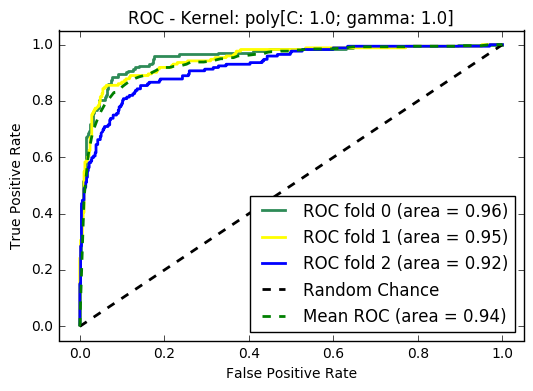

Kernel:  sigmoid Class:  0
Sat Oct 15 22:14:27 2016 - Start .....
Sat Oct 15 22:14:27 2016 - Before grid .....
Sat Oct 15 22:14:27 2016 - Before grid search .....
Sat Oct 15 22:14:27 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Sat Oct 15 22:14:29 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.74
Class:  0
Gamma:  1.0
    C:  1.0
# of features removed:  216
Sat Oct 15 22:14:29 2016 - iteration:  0
ROC fold 0 (area = 0.78)
Sat Oct 15 22:14:31 2016 - iteration:  1
ROC fold 1 (area = 0.73)
Sat Oct 15 22:14:33 2016 - iteration:  2
ROC fold 2 (area = 0.75)
Mean ROC (area = 0.75)
Sat Oct 15 22:14:35 2016 - best classifier probas


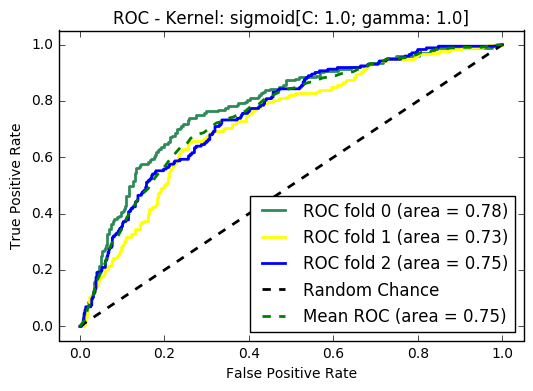

2000
Kernel:  linear Class:  1
Sat Oct 15 22:14:35 2016 - Start .....
Sat Oct 15 22:14:35 2016 - Before grid .....
Sat Oct 15 22:14:35 2016 - Before grid search .....
Sat Oct 15 22:14:35 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.2s finished


Sat Oct 15 22:14:41 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.71
Class:  1
Gamma:  1.0
    C:  1.0
# of features removed:  192
Sat Oct 15 22:14:41 2016 - iteration:  0
ROC fold 0 (area = 0.82)
Sat Oct 15 22:14:46 2016 - iteration:  1
ROC fold 1 (area = 0.78)
Sat Oct 15 22:14:50 2016 - iteration:  2
ROC fold 2 (area = 0.77)
Mean ROC (area = 0.79)
Sat Oct 15 22:14:54 2016 - best classifier probas


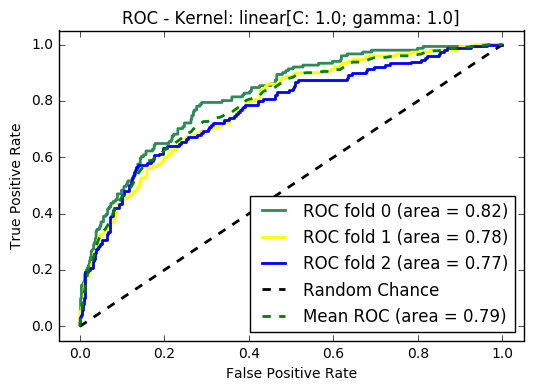

Kernel:  rbf Class:  1
Sat Oct 15 22:14:55 2016 - Start .....
Sat Oct 15 22:14:55 2016 - Before grid .....
Sat Oct 15 22:14:55 2016 - Before grid search .....
Sat Oct 15 22:14:55 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.3s finished


Sat Oct 15 22:14:58 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.77
Class:  1
Gamma:  1.0
    C:  1.0
# of features removed:  193
Sat Oct 15 22:14:58 2016 - iteration:  0
ROC fold 0 (area = 0.50)
Sat Oct 15 22:15:02 2016 - iteration:  1
ROC fold 1 (area = 0.50)
Sat Oct 15 22:15:07 2016 - iteration:  2
ROC fold 2 (area = 0.50)
Mean ROC (area = 0.50)
Sat Oct 15 22:15:11 2016 - best classifier probas


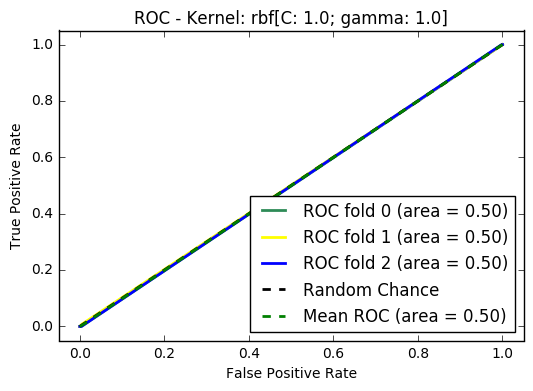

Kernel:  poly Class:  1
Sat Oct 15 22:15:12 2016 - Start .....
Sat Oct 15 22:15:12 2016 - Before grid .....
Sat Oct 15 22:15:12 2016 - Before grid search .....
Sat Oct 15 22:15:12 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.1s finished


Sat Oct 15 22:15:15 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.81
Class:  1
Gamma:  1.0
    C:  1.0
# of features removed:  188
Sat Oct 15 22:15:15 2016 - iteration:  0
ROC fold 0 (area = 0.84)
Sat Oct 15 22:15:18 2016 - iteration:  1
ROC fold 1 (area = 0.83)
Sat Oct 15 22:15:22 2016 - iteration:  2
ROC fold 2 (area = 0.81)
Mean ROC (area = 0.82)
Sat Oct 15 22:15:25 2016 - best classifier probas


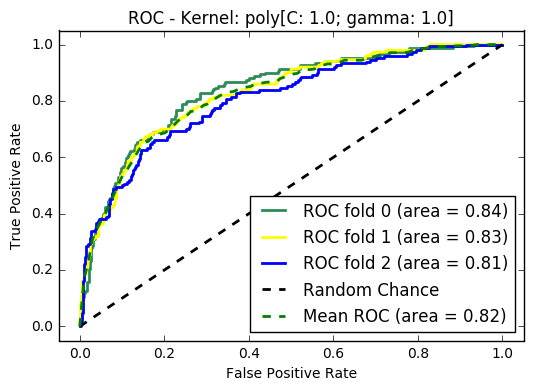

Kernel:  sigmoid Class:  1
Sat Oct 15 22:15:25 2016 - Start .....
Sat Oct 15 22:15:25 2016 - Before grid .....
Sat Oct 15 22:15:25 2016 - Before grid search .....
Sat Oct 15 22:15:25 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s finished


Sat Oct 15 22:15:27 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.77
Class:  1
Gamma:  1.0
    C:  1.0
# of features removed:  197
Sat Oct 15 22:15:27 2016 - iteration:  0
ROC fold 0 (area = 0.66)
Sat Oct 15 22:15:29 2016 - iteration:  1
ROC fold 1 (area = 0.68)
Sat Oct 15 22:15:31 2016 - iteration:  2
ROC fold 2 (area = 0.67)
Mean ROC (area = 0.67)
Sat Oct 15 22:15:33 2016 - best classifier probas


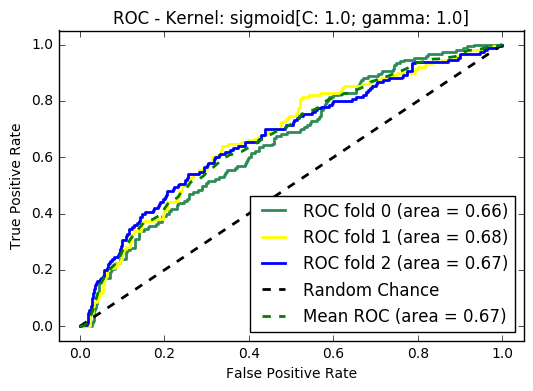

2000
Kernel:  linear Class:  2
Sat Oct 15 22:15:33 2016 - Start .....
Sat Oct 15 22:15:33 2016 - Before grid .....
Sat Oct 15 22:15:33 2016 - Before grid search .....
Sat Oct 15 22:15:33 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s finished


Sat Oct 15 22:15:36 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.82
Class:  2
Gamma:  1.0
    C:  1.0
# of features removed:  214
Sat Oct 15 22:15:36 2016 - iteration:  0
ROC fold 0 (area = 0.95)
Sat Oct 15 22:15:39 2016 - iteration:  1
ROC fold 1 (area = 0.93)
Sat Oct 15 22:15:42 2016 - iteration:  2
ROC fold 2 (area = 0.92)
Mean ROC (area = 0.93)
Sat Oct 15 22:15:44 2016 - best classifier probas


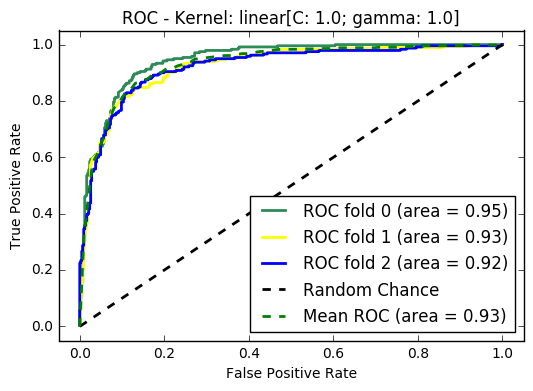

Kernel:  rbf Class:  2
Sat Oct 15 22:15:44 2016 - Start .....
Sat Oct 15 22:15:44 2016 - Before grid .....
Sat Oct 15 22:15:44 2016 - Before grid search .....
Sat Oct 15 22:15:44 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.4s finished


Sat Oct 15 22:15:48 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.64
Class:  2
Gamma:  1.0
    C:  1.0
# of features removed:  216
Sat Oct 15 22:15:48 2016 - iteration:  0
ROC fold 0 (area = 0.25)
Sat Oct 15 22:15:52 2016 - iteration:  1
ROC fold 1 (area = 0.30)
Sat Oct 15 22:15:55 2016 - iteration:  2
ROC fold 2 (area = 0.25)
Mean ROC (area = 0.26)
Sat Oct 15 22:15:59 2016 - best classifier probas


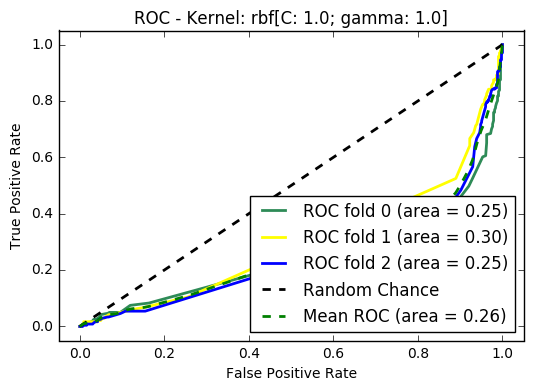

Kernel:  poly Class:  2
Sat Oct 15 22:16:00 2016 - Start .....
Sat Oct 15 22:16:00 2016 - Before grid .....
Sat Oct 15 22:16:00 2016 - Before grid search .....
Sat Oct 15 22:16:00 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.0s finished


Sat Oct 15 22:16:02 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.88
Class:  2
Gamma:  1.0
    C:  1.0
# of features removed:  215
Sat Oct 15 22:16:02 2016 - iteration:  0
ROC fold 0 (area = 0.94)
Sat Oct 15 22:16:05 2016 - iteration:  1
ROC fold 1 (area = 0.94)
Sat Oct 15 22:16:07 2016 - iteration:  2
ROC fold 2 (area = 0.94)
Mean ROC (area = 0.94)
Sat Oct 15 22:16:10 2016 - best classifier probas


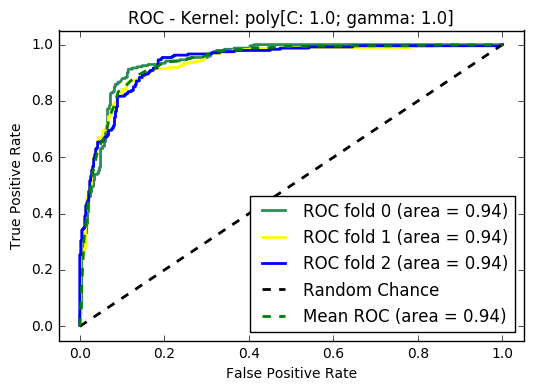

Kernel:  sigmoid Class:  2
Sat Oct 15 22:16:10 2016 - Start .....
Sat Oct 15 22:16:10 2016 - Before grid .....
Sat Oct 15 22:16:10 2016 - Before grid search .....
Sat Oct 15 22:16:10 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished


Sat Oct 15 22:16:13 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.64
Class:  2
Gamma:  1.0
    C:  1.0
# of features removed:  200
Sat Oct 15 22:16:13 2016 - iteration:  0
ROC fold 0 (area = 0.82)
Sat Oct 15 22:16:16 2016 - iteration:  1
ROC fold 1 (area = 0.84)
Sat Oct 15 22:16:18 2016 - iteration:  2
ROC fold 2 (area = 0.81)
Mean ROC (area = 0.82)
Sat Oct 15 22:16:21 2016 - best classifier probas


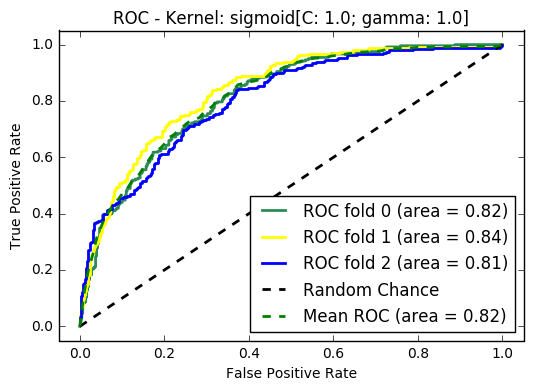

2000
Kernel:  linear Class:  3
Sat Oct 15 22:16:22 2016 - Start .....
Sat Oct 15 22:16:22 2016 - Before grid .....
Sat Oct 15 22:16:22 2016 - Before grid search .....
Sat Oct 15 22:16:22 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Sat Oct 15 22:16:25 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.75
Class:  3
Gamma:  1.0
    C:  1.0
# of features removed:  192
Sat Oct 15 22:16:25 2016 - iteration:  0
ROC fold 0 (area = 0.73)
Sat Oct 15 22:16:30 2016 - iteration:  1
ROC fold 1 (area = 0.69)
Sat Oct 15 22:16:34 2016 - iteration:  2
ROC fold 2 (area = 0.69)
Mean ROC (area = 0.70)
Sat Oct 15 22:16:38 2016 - best classifier probas


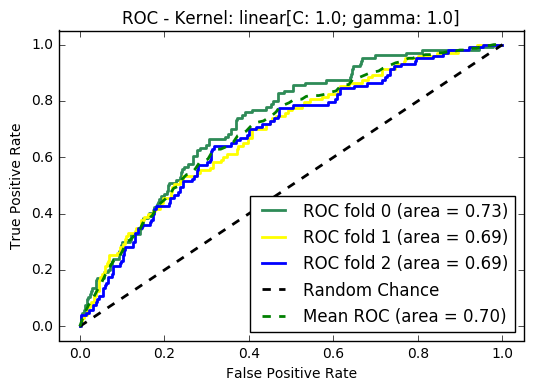

Kernel:  rbf Class:  3
Sat Oct 15 22:16:38 2016 - Start .....
Sat Oct 15 22:16:38 2016 - Before grid .....
Sat Oct 15 22:16:38 2016 - Before grid search .....
Sat Oct 15 22:16:38 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.3s finished


Sat Oct 15 22:16:42 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.84
Class:  3
Gamma:  1.0
    C:  1.0
# of features removed:  178
Sat Oct 15 22:16:42 2016 - iteration:  0
ROC fold 0 (area = 0.50)
Sat Oct 15 22:16:47 2016 - iteration:  1
ROC fold 1 (area = 0.50)
Sat Oct 15 22:16:52 2016 - iteration:  2
ROC fold 2 (area = 0.50)
Mean ROC (area = 0.50)
Sat Oct 15 22:16:56 2016 - best classifier probas


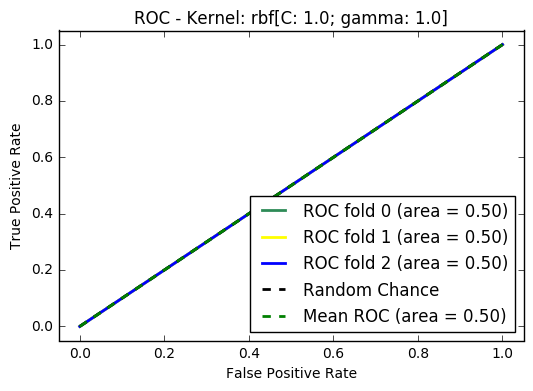

Kernel:  poly Class:  3
Sat Oct 15 22:16:57 2016 - Start .....
Sat Oct 15 22:16:57 2016 - Before grid .....
Sat Oct 15 22:16:57 2016 - Before grid search .....
Sat Oct 15 22:16:57 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.1s finished


Sat Oct 15 22:17:00 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.84
Class:  3
Gamma:  1.0
    C:  1.0
# of features removed:  177
Sat Oct 15 22:17:00 2016 - iteration:  0
ROC fold 0 (area = 0.73)
Sat Oct 15 22:17:04 2016 - iteration:  1
ROC fold 1 (area = 0.73)
Sat Oct 15 22:17:07 2016 - iteration:  2
ROC fold 2 (area = 0.69)
Mean ROC (area = 0.72)
Sat Oct 15 22:17:11 2016 - best classifier probas


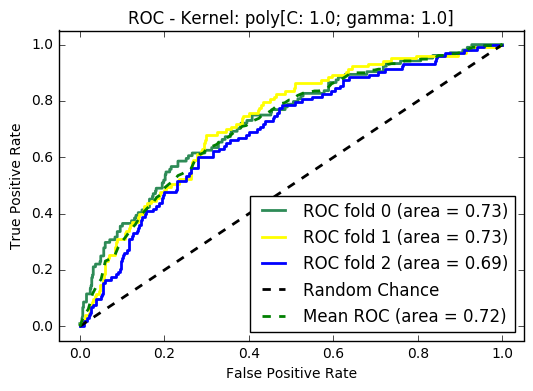

Kernel:  sigmoid Class:  3
Sat Oct 15 22:17:12 2016 - Start .....
Sat Oct 15 22:17:12 2016 - Before grid .....
Sat Oct 15 22:17:12 2016 - Before grid search .....
Sat Oct 15 22:17:12 2016 - Before grid fit .....
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s finished


Sat Oct 15 22:17:13 2016 - After grid fit .....
The best parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.84
Class:  3
Gamma:  1.0
    C:  1.0
# of features removed:  180
Sat Oct 15 22:17:13 2016 - iteration:  0
ROC fold 0 (area = 0.48)
Sat Oct 15 22:17:14 2016 - iteration:  1
ROC fold 1 (area = 0.54)
Sat Oct 15 22:17:16 2016 - iteration:  2
ROC fold 2 (area = 0.50)
Mean ROC (area = 0.51)
Sat Oct 15 22:17:17 2016 - best classifier probas


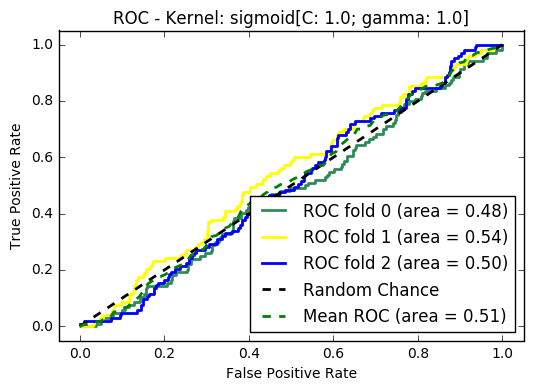

In [7]:
#------
# MAIN
#------

import warnings
warnings.filterwarnings("ignore")


# Read data from files
# set num_rows to pick subset for faster test runs, else set it to 0

# Here we control the number of rows to process. With small subset of data, it gives us the ability to 
# iteratively experiment with multiple runs of the code. Once we felt it was good enough to scale it up 
# to full data set, we set the num_rows to 0 to process all input data.

num_rows = 2000
if num_rows > 0:
   trainX = pandas.read_csv('data/trainingData.txt', sep = '\t', header = None, nrows=num_rows)
   trainY = pandas.read_csv('data/trainingTruth.txt', sep = '\t', header = None, nrows=num_rows)
   testX = pandas.read_csv('data/blindData.txt', sep = '\t', header = None, nrows=num_rows)
else:
   trainX = pandas.read_csv('data/trainingData.txt', sep = '\t', header = None)
   trainY = pandas.read_csv('data/trainingTruth.txt', sep = '\t', header = None)
   testX = pandas.read_csv('data/blindData.txt', sep = '\t', header = None)

# Input for kNN vs fillzero flag
#     0 - replace NA with 0
#     1 - replace NA using kNN
knn_yes = 0

if knn_yes == 1:
    print('Replace/Fill NA /w values using kNN...')
    trainX = fill_missing_data(trainX, trainY, k = 10)
    fill_flag='fillKNN'
else:
    trainX = trainX.fillna(0)
    fill_flag='fillZEROS'

trainY = 'trainingTruth.txt'
input_y_all = binarize(trainY)

X = trainX.as_matrix()
XT = testX.as_matrix()


# validate the rows read
print(len(X), len(XT))

n_samples, n_features = X.shape
# validate rows read for test data
print(len(XT))

# iterate through all 4 classes
all_probs = []
for cls in range(4):
    if num_rows > 0:
        y = input_y_all[cls][0:num_rows]
    else:
        y = input_y_all[cls]
        
    # validate number of class values
    print(len(y))

    # we decided to evaluate 4 kernels for our choice of the classifier as SVM
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']

    for i,k in enumerate(kernels):
        print('Kernel: ', k, 'Class: ', cls)
        
        # here we are using a small number of C and gamma for easier execution times
        C_range = [1.0, 10]
        gamma_range = [1.0, 10]

        # do grid search for C and gamma
        grid = get_c_gamma_pll(X, y, k, C_range, gamma_range)
        print('Class: ', cls)
        C = grid.best_params_['C']
        gamma = grid.best_params_['gamma']

        print('Gamma: ', gamma)
        print('    C: ', C)

        # set do_plot to 1 to do plots, else set it to 0 to skip
        do_plot = 1
        
        # Do the classification, plot the ROC Curve ad output AUC
        probs = do_classification(X, y, (cls+1), XT, k, gamma, C, do_plot)
        
        # save ll probabilities, in our current setting, expecting 16 columns - 4 class and 4 kernels
        # in the execution with full data, we just had one kernel, initially 'linear', ten 'poly'
        # that woudl produce the 4 column output of probabilities for the submittal/upload each day
        all_probs.append(probs)
        
# save all probabilities as tab seperated values in the file
pd = pandas.DataFrame(all_probs).T
pd['class'] = pd.idxmax(axis=1) + 1
pd.to_csv("data/HW3_Probs_Output_01.csv", index=False, header=False, sep="\t")

We can conclude from the above ROC curves above the kernels rbf and sigmoid can be safely eliminated as they have very poor Area Under the Curves as evident from the ROC curves. From the above result, we decide to explore poly and linear kernels more to decide which of the fits is the best.

We did not use feature selection or missing data replacement for the first few runs, we only incorporated them for our final runs. We have explicitly stated the C and Gammas used for our initial submissions, although the ROC curves may express different results as this notebook the new algorithms. 

WARNING: We used another python notebook that is included in the zip for our submission to calculate the submission files on the test data. 

Below we will discuss our submissions and the models we submitted. 

For the submission on October 9th 2016, we submitted a baseline model using the results from above. The kernels used was linear, with a C equal to 1 for all claases and Gamma equal to 1 for classes 1, 3 and 4, and 10 for class 2. We did not use the feature selection or replace missing data algorithms, these were lated added. This performed farily well for just the baseline with resulting Area Under the Curve scores of:

AUC for Class 1: 0.9618

AUC for Class 2: 0.8501

AUC for Class 3: 0.9513

AUC for Class 4: 0.7464

For the submission on October 10th, we decided to find a better penalty and regularizing parameter for the same kernel of linear. We hoped that this would result in a better fit. Below is our search for the parameters for a larger range of gammas and Cs.

2000
Kernel:  linear Class:  0
Sat Oct 15 22:42:34 2016 - Start .....
Sat Oct 15 22:42:34 2016 - Before grid .....
Sat Oct 15 22:42:34 2016 - Before grid search .....
Sat Oct 15 22:42:34 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.2s finished


Sat Oct 15 22:42:36 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.89
Class:  0
Gamma:  0.1
    C:  0.1
# of features removed:  217
Sat Oct 15 22:42:36 2016 - iteration:  0
ROC fold 0 (area = 0.95)
Sat Oct 15 22:42:37 2016 - iteration:  1
ROC fold 1 (area = 0.95)
Sat Oct 15 22:42:38 2016 - iteration:  2
ROC fold 2 (area = 0.93)
Mean ROC (area = 0.94)
Sat Oct 15 22:42:39 2016 - best classifier probas


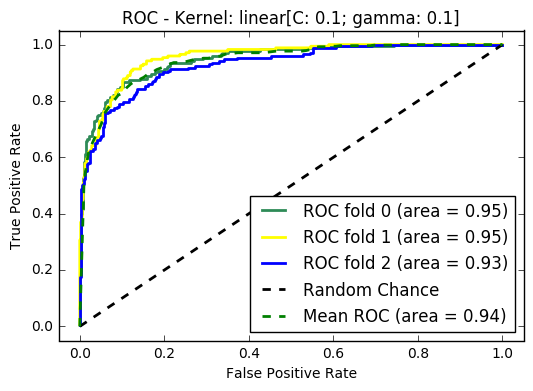

2000
Kernel:  linear Class:  1
Sat Oct 15 22:42:39 2016 - Start .....
Sat Oct 15 22:42:39 2016 - Before grid .....
Sat Oct 15 22:42:39 2016 - Before grid search .....
Sat Oct 15 22:42:39 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    0.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.9s finished


Sat Oct 15 22:42:44 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.77
Class:  1
Gamma:  0.1
    C:  0.1
# of features removed:  193
Sat Oct 15 22:42:44 2016 - iteration:  0
ROC fold 0 (area = 0.85)
Sat Oct 15 22:42:45 2016 - iteration:  1
ROC fold 1 (area = 0.81)
Sat Oct 15 22:42:47 2016 - iteration:  2
ROC fold 2 (area = 0.80)
Mean ROC (area = 0.82)
Sat Oct 15 22:42:49 2016 - best classifier probas


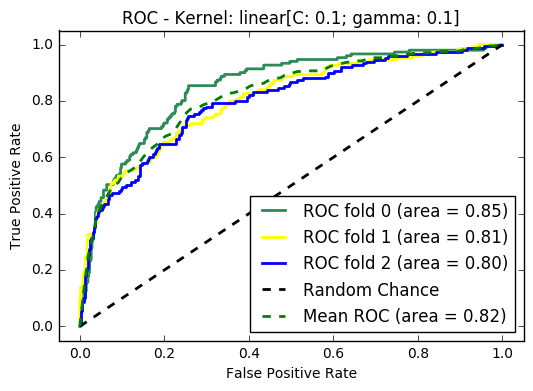

2000
Kernel:  linear Class:  2
Sat Oct 15 22:42:49 2016 - Start .....
Sat Oct 15 22:42:49 2016 - Before grid .....
Sat Oct 15 22:42:49 2016 - Before grid search .....
Sat Oct 15 22:42:49 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    0.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.3s finished


Sat Oct 15 22:42:52 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.84
Class:  2
Gamma:  0.1
    C:  0.1
# of features removed:  219
Sat Oct 15 22:42:52 2016 - iteration:  0
ROC fold 0 (area = 0.94)
Sat Oct 15 22:42:53 2016 - iteration:  1
ROC fold 1 (area = 0.93)
Sat Oct 15 22:42:54 2016 - iteration:  2
ROC fold 2 (area = 0.92)
Mean ROC (area = 0.93)
Sat Oct 15 22:42:55 2016 - best classifier probas


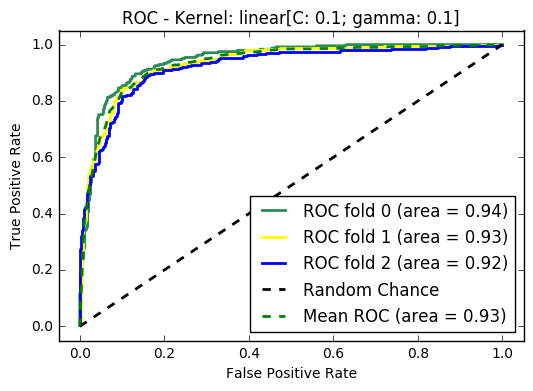

2000
Kernel:  linear Class:  3
Sat Oct 15 22:42:56 2016 - Start .....
Sat Oct 15 22:42:56 2016 - Before grid .....
Sat Oct 15 22:42:56 2016 - Before grid search .....
Sat Oct 15 22:42:56 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.5s finished


Sat Oct 15 22:42:58 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.79
Class:  3
Gamma:  0.1
    C:  0.1
# of features removed:  179
Sat Oct 15 22:42:58 2016 - iteration:  0
ROC fold 0 (area = 0.73)
Sat Oct 15 22:43:00 2016 - iteration:  1
ROC fold 1 (area = 0.74)
Sat Oct 15 22:43:02 2016 - iteration:  2
ROC fold 2 (area = 0.67)
Mean ROC (area = 0.71)
Sat Oct 15 22:43:04 2016 - best classifier probas


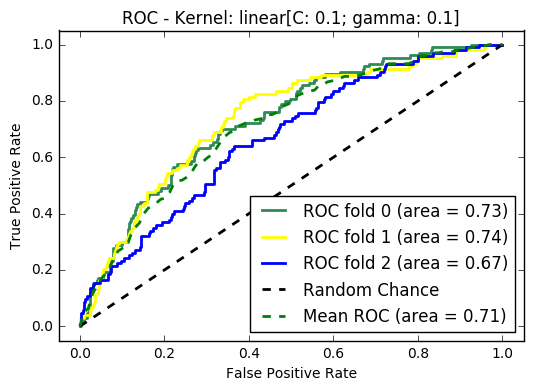

In [11]:
# iterate through all 4 classes
all_probs = []
for cls in range(4):
    if num_rows > 0:
        y = input_y_all[cls][0:num_rows]
    else:
        y = input_y_all[cls]
        
    # validate number of class values
    print(len(y))

    # we decided to evaluate 4 kernels for our choice of the classifier as SVM
    kernels = ['linear']

    for i,k in enumerate(kernels):
        print('Kernel: ', k, 'Class: ', cls)
        
        # here we are using a small number of C and gamma for easier execution times
        C_range = [0.1,0.5, 1.0, 5, 10, 100]
        gamma_range = [0.1,0.5, 1.0, 5, 10, 100]

        # do grid search for C and gamma
        grid = get_c_gamma_pll(X, y, k, C_range, gamma_range)
        print('Class: ', cls)
        C = grid.best_params_['C']
        gamma = grid.best_params_['gamma']

        print('Gamma: ', gamma)
        print('    C: ', C)

        # set do_plot to 1 to do plots, else set it to 0 to skip
        do_plot = 1
        
        # Do the classification, plot the ROC Curve ad output AUC
        probs = do_classification(X, y, (cls+1), XT, k, gamma, C, do_plot)
        
        # save ll probabilities, in our current setting, expecting 16 columns - 4 class and 4 kernels
        # in the execution with full data, we just had one kernel, initially 'linear', ten 'poly'
        # that woudl produce the 4 column output of probabilities for the submittal/upload each day
        all_probs.append(probs)
        
# save all probabilities as tab seperated values in the file
pd = pandas.DataFrame(all_probs).T
pd['class'] = pd.idxmax(axis=1) + 1
pd.to_csv("data/HW3_Probs_Output_02.csv", index=False, header=False, sep="\t")

This may not reflect the above ROC curves because feature selection and missing data replacement were used in this notebook, as earlire stated. We used C of 0.5 for classes 1 and 4, 5 for class 2 and 1 for class 3. We used gamma of 0.1 for all classes. The kernel used is linear. 

With good AUC scores in our validation. We submitted our test submission using this C and gamma to predict the test classes and our results were comparable to the first run, with resulting Area Under the Curve scores of:

AUC for Class 1: 0.9618

AUC for Class 2: 0.8505

AUC for Class 3: 0.9513

AUC for Class 4: 0.7434

There was hardly any change in the two runs. To better the model, we train the model on a poly kernel for a large variety of C and gamma. 

2000
Kernel:  poly Class:  0
Sat Oct 15 22:44:52 2016 - Start .....
Sat Oct 15 22:44:52 2016 - Before grid .....
Sat Oct 15 22:44:52 2016 - Before grid search .....
Sat Oct 15 22:44:52 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    1.7s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.8s finished


Sat Oct 15 22:44:56 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.92
Class:  0
Gamma:  0.1
    C:  0.1
# of features removed:  219
Sat Oct 15 22:44:56 2016 - iteration:  0
ROC fold 0 (area = 0.97)
Sat Oct 15 22:44:59 2016 - iteration:  1
ROC fold 1 (area = 0.95)
Sat Oct 15 22:45:01 2016 - iteration:  2
ROC fold 2 (area = 0.94)
Mean ROC (area = 0.95)
Sat Oct 15 22:45:03 2016 - best classifier probas


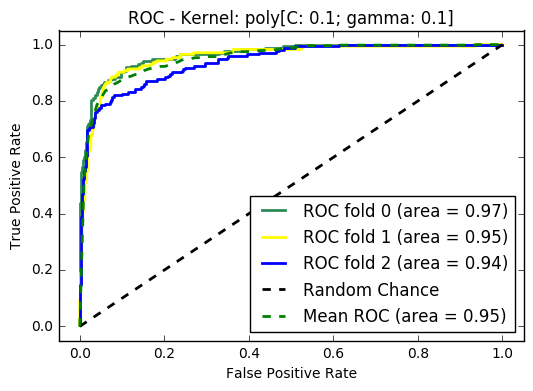

2000
Kernel:  poly Class:  1
Sat Oct 15 22:45:03 2016 - Start .....
Sat Oct 15 22:45:03 2016 - Before grid .....
Sat Oct 15 22:45:03 2016 - Before grid search .....
Sat Oct 15 22:45:03 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    2.5s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    3.7s finished


Sat Oct 15 22:45:09 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.81
Class:  1
Gamma:  0.1
    C:  0.1
# of features removed:  189
Sat Oct 15 22:45:09 2016 - iteration:  0
ROC fold 0 (area = 0.82)
Sat Oct 15 22:45:12 2016 - iteration:  1
ROC fold 1 (area = 0.79)
Sat Oct 15 22:45:16 2016 - iteration:  2
ROC fold 2 (area = 0.81)
Mean ROC (area = 0.80)
Sat Oct 15 22:45:19 2016 - best classifier probas


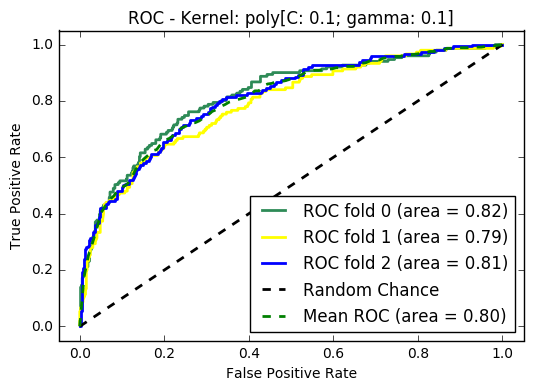

2000
Kernel:  poly Class:  2
Sat Oct 15 22:45:20 2016 - Start .....
Sat Oct 15 22:45:20 2016 - Before grid .....
Sat Oct 15 22:45:20 2016 - Before grid search .....
Sat Oct 15 22:45:20 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    1.9s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.7s finished


Sat Oct 15 22:45:24 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.88
Class:  2
Gamma:  0.1
    C:  0.1
# of features removed:  210
Sat Oct 15 22:45:24 2016 - iteration:  0
ROC fold 0 (area = 0.95)
Sat Oct 15 22:45:27 2016 - iteration:  1
ROC fold 1 (area = 0.94)
Sat Oct 15 22:45:29 2016 - iteration:  2
ROC fold 2 (area = 0.93)
Mean ROC (area = 0.94)
Sat Oct 15 22:45:32 2016 - best classifier probas


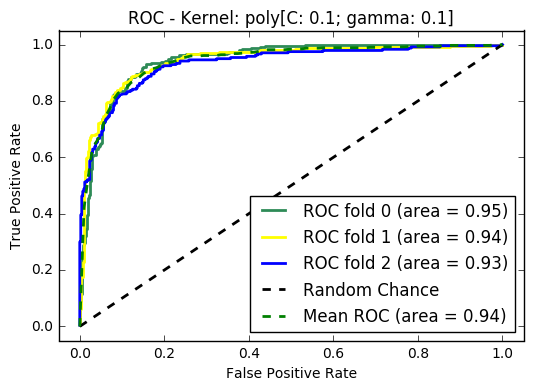

2000
Kernel:  poly Class:  3
Sat Oct 15 22:45:32 2016 - Start .....
Sat Oct 15 22:45:32 2016 - Before grid .....
Sat Oct 15 22:45:32 2016 - Before grid search .....
Sat Oct 15 22:45:32 2016 - Before grid fit .....
Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  18 out of  72 | elapsed:    3.2s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    4.3s finished


Sat Oct 15 22:45:38 2016 - After grid fit .....
The best parameters are {'C': 0.1, 'gamma': 0.1} with a score of 0.84
Class:  3
Gamma:  0.1
    C:  0.1
# of features removed:  179
Sat Oct 15 22:45:38 2016 - iteration:  0
ROC fold 0 (area = 0.77)
Sat Oct 15 22:45:42 2016 - iteration:  1
ROC fold 1 (area = 0.73)
Sat Oct 15 22:45:45 2016 - iteration:  2
ROC fold 2 (area = 0.71)
Mean ROC (area = 0.74)
Sat Oct 15 22:45:49 2016 - best classifier probas


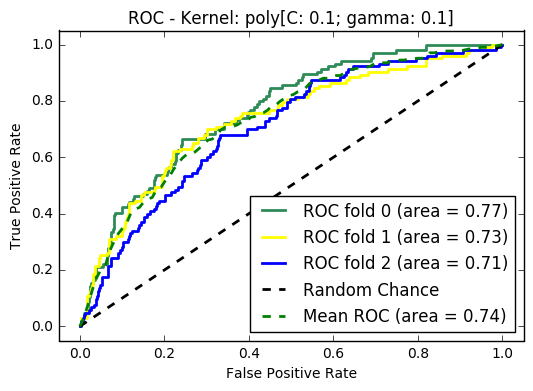

In [13]:
# iterate through all 4 classes
all_probs = []
for cls in range(4):
    if num_rows > 0:
        y = input_y_all[cls][0:num_rows]
    else:
        y = input_y_all[cls]
        
    # validate number of class values
    print(len(y))

    # we decided to evaluate 4 kernels for our choice of the classifier as SVM
    kernels = ['poly']

    for i,k in enumerate(kernels):
        print('Kernel: ', k, 'Class: ', cls)
        
        # here we are using a small number of C and gamma for easier execution times
        C_range = [0.1,0.5, 1.0, 5, 10, 100]
        gamma_range = [0.1,0.5, 1.0, 5, 10, 100]


        # do grid search for C and gamma
        grid = get_c_gamma_pll(X, y, k, C_range, gamma_range)
        print('Class: ', cls)
        C = grid.best_params_['C']
        gamma = grid.best_params_['gamma']

        print('Gamma: ', gamma)
        print('    C: ', C)

        # set do_plot to 1 to do plots, else set it to 0 to skip
        do_plot = 1
        
        # Do the classification, plot the ROC Curve ad output AUC
        probs = do_classification(X, y, (cls+1), XT, k, gamma, C, do_plot)
        
        # save ll probabilities, in our current setting, expecting 16 columns - 4 class and 4 kernels
        # in the execution with full data, we just had one kernel, initially 'linear', ten 'poly'
        # that woudl produce the 4 column output of probabilities for the submittal/upload each day
        all_probs.append(probs)
        
# save all probabilities as tab seperated values in the file
pd = pandas.DataFrame(all_probs).T
pd['class'] = pd.idxmax(axis=1) + 1
pd.to_csv("data/HW3_Probs_Output_03.csv", index=False, header=False, sep="\t")

This may not reflect the above ROC curves because feature selection and missing data replacement were used in this notebook, as earlire stated. We used C of 0.5 for all classes. We used gamma of 0.1 for classes 1, 2 and 3, and 5 for class 4. The kernel used is poly. 

With good AUC scores in our validation. We submitted our test submission using this C and gamma to predict the test classes and our results were far better compared to the other runs, with resulting Area Under the Curve scores of:

AUC for Class 1: 0.9775

AUC for Class 2: 0.8771

AUC for Class 3: 0.9581

AUC for Class 4: 0.8114

For our final run, we add mssing data replacement and feature selection to better classify the data. Those C's and Gamma's are mentioned in the other Python script. Below you can see what parameters and functions were used for each run. 

| Run Date | Kernel | C for Classes 1, 2, 3, 4 | Gamma for Classes 1, 2, 3, 4| Missing Data Replaced using KNN | Feature Selection   
| :- | -------------: | -------------: | -------------: | :-: |
| October 9 | Linear | 1, 1, 1, 1 | 1, 10, 1, 1| No | No    
| October 10 | Linear | 0.5, 5, 1, 0.5 | 0.1, 0.1, 0.1, 0.1| No | No    
| October 11 | Poly | 0.5, 0.5, 0.5, 0.5 | 0.1, 0.1, 0.1, 5| No | No    
| October 12 | Linear | 1, 1, 1, 1 | 1, 10, 1, 1| No | No    
| Final Test| Poly | 0.5, 0.5, 0.5, 0.5 | 0.1, 0.1, 0.1, 0.5| No | Yes    
| Final | Poly | 0.5, 0.5, 0.5, 0.5 | 0.1, 0.1, 0.1, 0.1| Yes | Yes    
